In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import yaml
import os
from datetime import datetime
import numpy as np
from utils import get_config, resolve_path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Custom modules
from BaseDataset import BaseHDF5Dataset
from QuasarDataset import QuasarDataset
from model import Generator
from tqdm import tqdm
from checkpoint import save_checkpoint, load_checkpoint

In [3]:
def initialize_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [8]:
def load_configurations():
    config = get_config()
    data_path = resolve_path(config['datasets']['boss']['path'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    latent_path = resolve_path(config['paths']['latent'])
    plots_path = resolve_path(config['paths']['plots'])
    tensorboard_path = resolve_path(config['paths']['tensorboard'])

    batch_size = config['training']['batch_size']
    num_workers = config['training']['num_workers']
    num_epochs = config['training']['num_epochs']
    learning_rate = config['training']['learning_rate']
    latent_learning_rate = config['training']['latent_learning_rate']
    latent_dim = config['training']['latent_dim']
    checkpoint_interval = config['training']['checkpoint_interval']

    return (config, data_path, checkpoints_path, latent_path, plots_path, tensorboard_path,
            batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval)

In [9]:
def weighted_mse(input, target, weight):
    assert input.shape == target.shape == weight.shape, f'Shapes of input {input.shape}, target {target.shape}, and weight {weight.shape} must match'
    loss = torch.mean(weight * (input - target) ** 2)
    return loss

In [18]:
def plot_real_vs_generated_batch(checkpoints_path, latent_path, data_loader, generator, device, batch_index, plots_path):
    # Load the latest latent codes
    latent_files = sorted(os.listdir(latent_path))
    last_latent_file = os.path.join(latent_path, latent_files[-1])
    latents = np.load(last_latent_file, allow_pickle=True).item()
    
    # Find the specific batch
    batch = None
    for i, batch_data in enumerate(data_loader):
        if i == batch_index:
            batch = batch_data
            break

    # Ensure the batch is found
    if batch is None:
        raise ValueError(f"Batch index {batch_index} not found in the data loader.")
    
    # Extract the indexes and spectra from the batch
    indices = batch['spectrum_index']
    real_spectra = batch['flux']
    masks = batch['mask']
    
    # Generate the spectra using the generator model
    generator.eval()
    with torch.no_grad():
        latent_codes = torch.tensor(latents['latent_codes'][indices]).to(device)
        generated_spectra = generator(latent_codes).cpu().numpy()
    
    # Plot real vs generated spectra for each index in the batch
    for i, index in enumerate(indices):
        real_spectrum = real_spectra[i].cpu().numpy()
        generated_spectrum = generated_spectra[i]
        mask = masks[i].cpu()

        mse = weighted_mse(torch.tensor(generated_spectrum), torch.tensor(real_spectrum), mask).item()

        # Calculate min and max values for y-axis limits
        all_values = real_spectrum + generated_spectrum
        y_min = min(all_values)
        y_max = max(all_values)
    
        # Add padding
        padding = 0.1 * (y_max - y_min)
        y_min += padding
        y_max -= padding
        
        
        plt.figure(figsize=(10, 5))
        plt.plot(real_spectrum, label='Real Spectrum', color='blue', alpha=0.7, linewidth=0.5)
        plt.plot(generated_spectrum, label='Generated Spectrum', color='red', alpha=0.7, linewidth=0.5)
        plt.title(f'Comparison of Real and Generated Spectra for Spectrum Index {index}\nMasked MSE: {mse:.4f}')
        plt.ylim(y_min,y_max)
        plt.xlabel('Wavelength Index')
        plt.ylabel('Flux')
        plt.legend()
        plt.grid(True)
        
        plt.savefig(os.path.join(plots_path, f'real_vs_generated_{index}.png'))

        plt.show()
        plt.close()

initializing device ..
Using device: cuda
loading config..


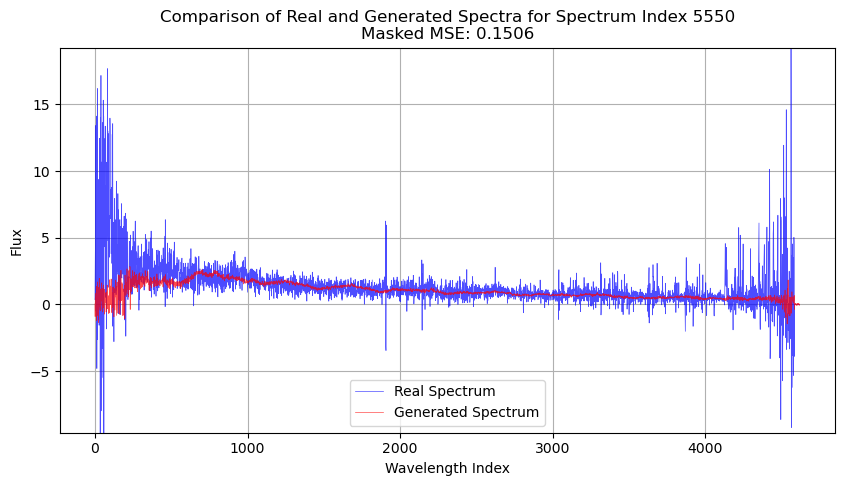

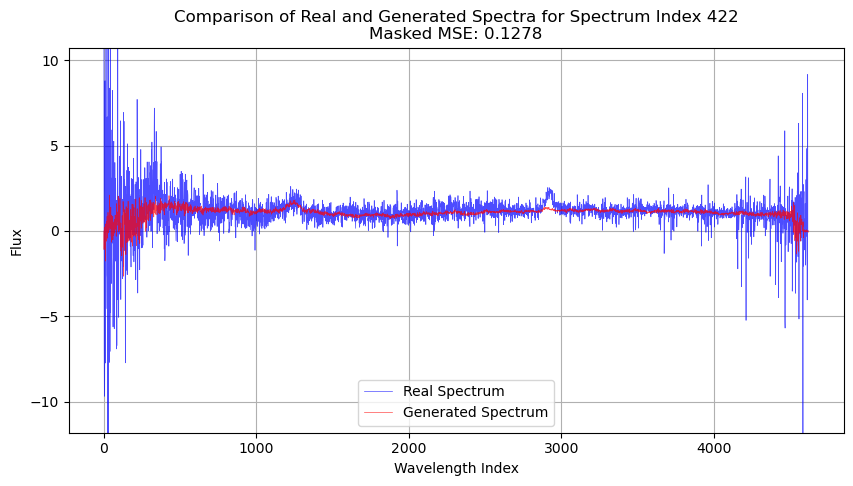

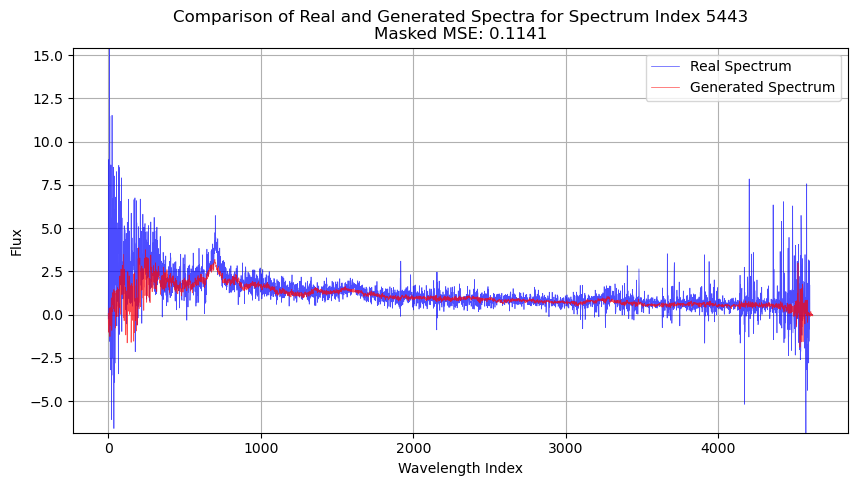

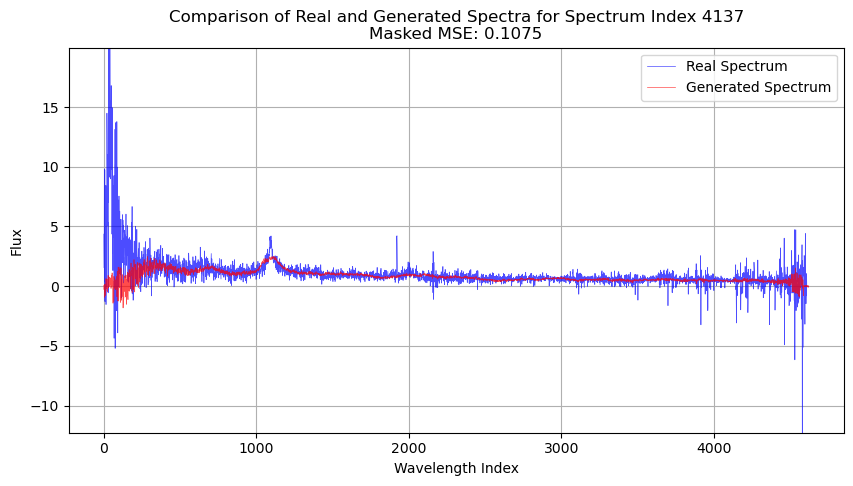

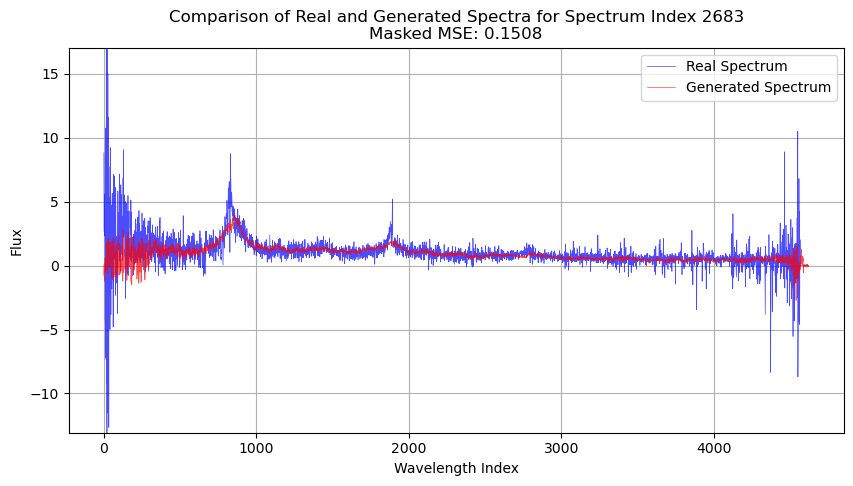

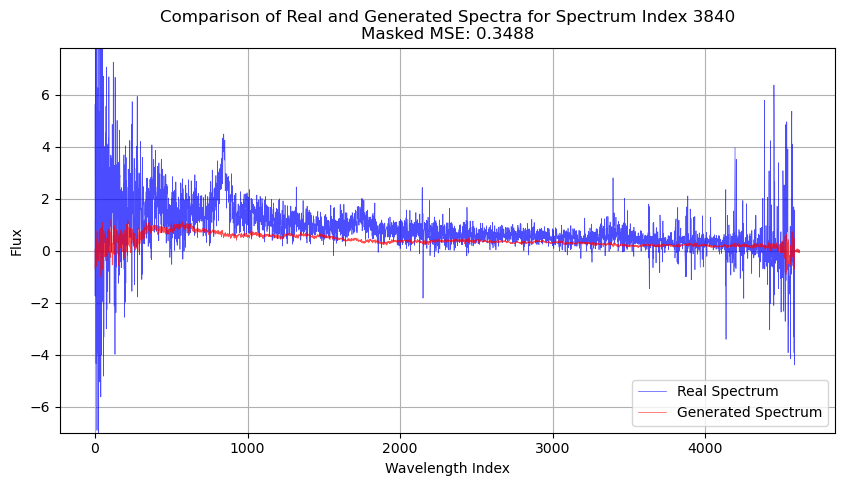

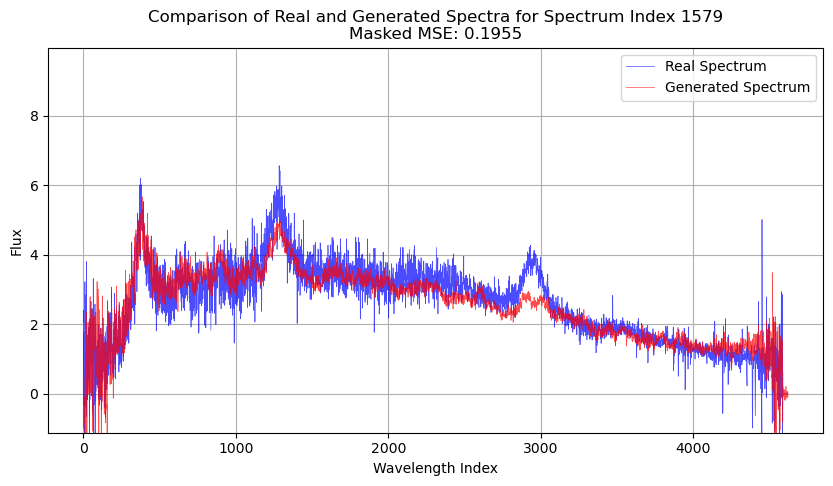

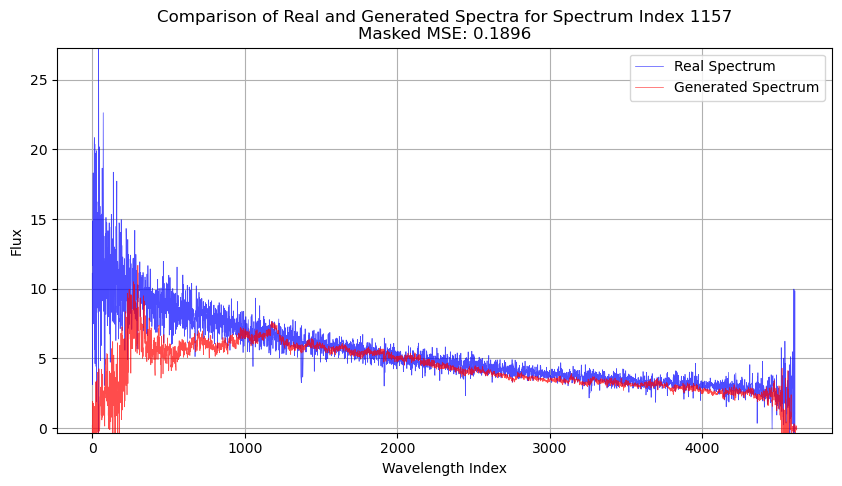

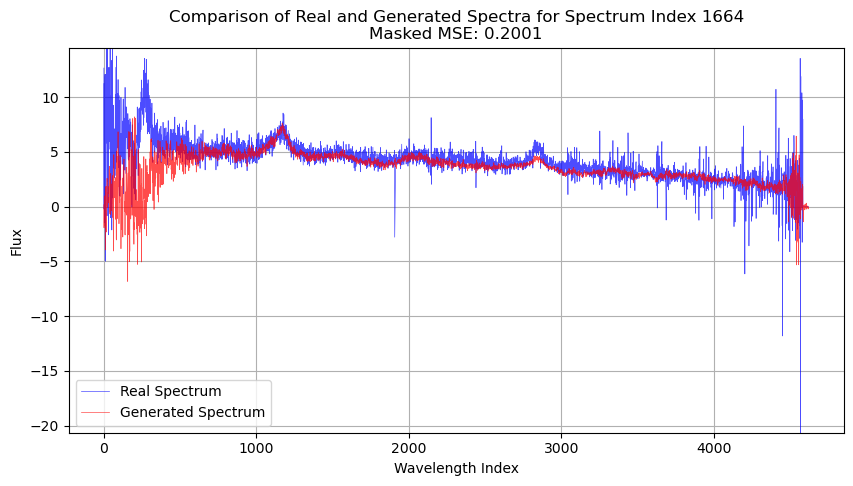

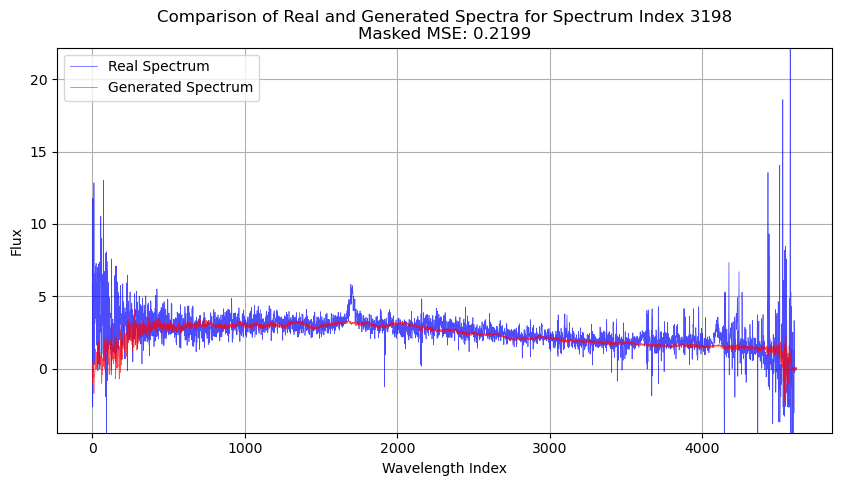

In [21]:
print("initializing device ..")
device = initialize_device()
print("loading config..")
(config, data_path, checkpoints_path, latent_path, plots_path, tensorboard_path,
 batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval) = load_configurations()

# Initialize the dataset and data loader
dataset = QuasarDataset(data_path, max_files=config['training']['max_files'])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Initialize the generator model
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'], config['model']['activation_function']).to(device)

# Load the latest checkpoint if available
latest_checkpoint_path = os.path.join(checkpoints_path, 'checkpoint_latest.pth.tar')
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    generator.load_state_dict(checkpoint['state_dict'])

# Plot the real vs generated spectra for the batch of index batc_index
batch_index = 10
plot_real_vs_generated_batch(checkpoints_path, latent_path, train_loader, generator, device, batch_index, plots_path)

In [54]:
#Evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_errors(true_spectra, generated_spectra, mask):
    """
    Calculate the errors between true spectra and generated spectra.
    
    Parameters:
    true_spectra (numpy array): The true spectra data.
    generated_spectra (numpy array): The generated spectra data.
    
    Returns:
    numpy array: Errors between true and generated spectra.
    """
    return abs(mask*(true_spectra - generated_spectra))

def plot_error_distribution(errors, wavelengths):
    """
    Plot the error distribution across wavelengths.
    
    Parameters:
    errors (numpy array): Errors between true and generated spectra.
    wavelengths (numpy array): Wavelengths corresponding to the spectra data.
    """
    for i in range(errors.shape[1]):
        sns.histplot(errors[:, i], kde=True, label=f'Wavelength {wavelengths[i]}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution Across Wavelengths')
    plt.legend()
    plt.show()

def calculate_mean_error(errors, wavelengths):
    # Collecter tous les indices présents dans les données de longueur d'onde
    all_wavelengths = np.concatenate(wavelengths)
    unique_wavelengths = np.unique(all_wavelengths)[np.unique(all_wavelengths)!=0]

    # Initialiser un tableau pour les moyennes de true_spectra
    mean_errors = np.zeros_like(unique_wavelengths, dtype=float)

    # Calculer la moyenne des true_spectra pour chaque longueur d'onde unique
    for i, wavelength in enumerate(unique_wavelengths):
        # Sélectionner les true_spectra correspondant à cette longueur d'onde dans chaque jeu de données
        error_here = []
        for j in range(len(wavelengths)):
            if wavelength in wavelengths[j]:
                error_here.append(errors[j][np.where(wavelengths[j] == wavelength)[0][0]])
    
        # Calculer la moyenne des true_spectra pour cette longueur d'onde
        mean_errors[i] = np.mean(error_here)
    return(mean_errors, unique_wavelengths)

def plot_errors_spectra_over_epochs(generator, spectrum_indexes, dataset, epochs, device):
    true_spectra = []
    wavelengths = []
    masks = []
    for i in range(len(spectrum_indexes)):
        true_spectra.append(dataset[spectrum_indexes[i]]['flux'])
        wavelengths.append(dataset[spectrum_indexes[i]]['wavelength'])
        masks.append(dataset[spectrum_indexes[i]]['mask'])
    for i, epoch in enumerate(epochs):
        # Load the checkpoint if available
        checkpoint_path = os.path.join(checkpoints_path, f'checkpoint_epoch_{epoch+1}.pth.tar')
        if os.path.exists(checkpoint_path):
            checkpoint = load_checkpoint(checkpoint_path)
            generator.load_state_dict(checkpoint['state_dict'])
        # Load latent
        latents_path = os.path.join(latent_path, f'latent_codes_epoch_{epoch+1}.npy')
        if os.path.exists(checkpoint_path):
            latents = np.load(latents_path, allow_pickle=True).item()
        
        # Generate the spectra using the generator model
        generator.eval()
        with torch.no_grad():
            latent_codes = torch.tensor(latents['latent_codes'][spectrum_indexes]).to(device)
            generated_spectra = generator(latent_codes).cpu().numpy()

        errors = []
        for j in range(len(spectrum_indexes)):
            errors.append(calculate_errors(true_spectra[j],generated_spectra[j],masks[j]))

        mean_errors, unique_wavelengths = calculate_mean_error(errors, wavelengths)
        plt.figure(figsize=(10, 5))
        plt.plot(unique_wavelengths, mean_errors, label='Mean Absolute Weighted Error', color='red', alpha=0.7, linewidth=0.5)
        plt.title(f'Mean Absolute Weighted Error at Epoch {epoch+1}')
        plt.xlabel('Wavelength Index')
        plt.ylabel('Mean Weighted Error')
        plt.legend()
        plt.grid(True)
        
        plt.savefig(os.path.join(plots_path, f'evaluate_epoch_{epoch+1}.png'))

        plt.show()
        plt.close()

initializing device ..
Using device: cuda
loading config..
Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_1.pth.tar'


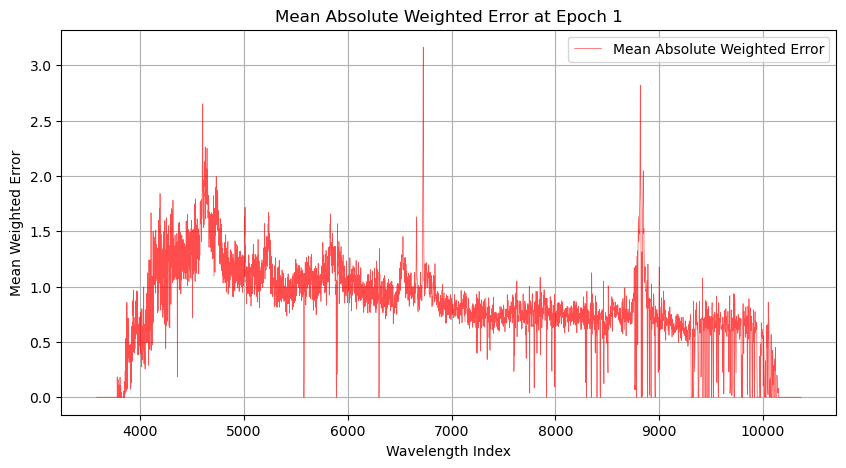

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_101.pth.tar'


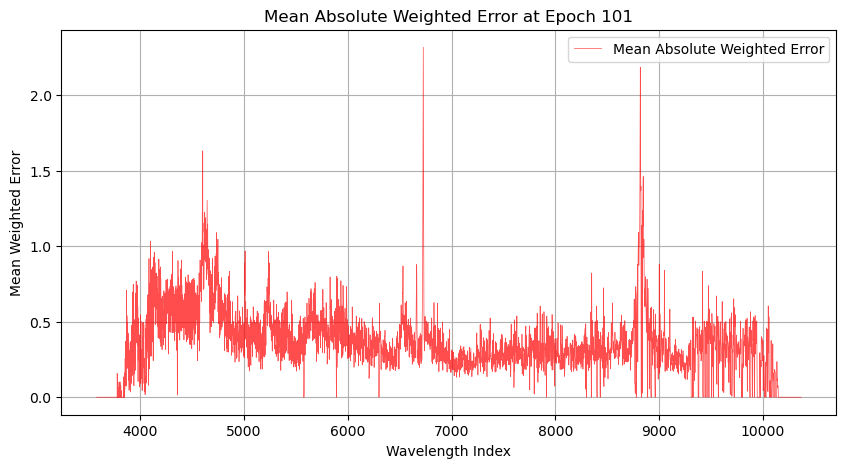

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_201.pth.tar'


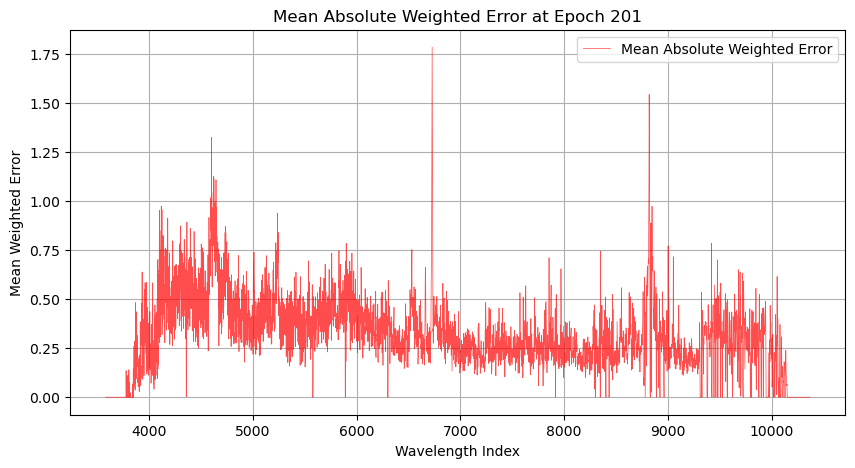

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_301.pth.tar'


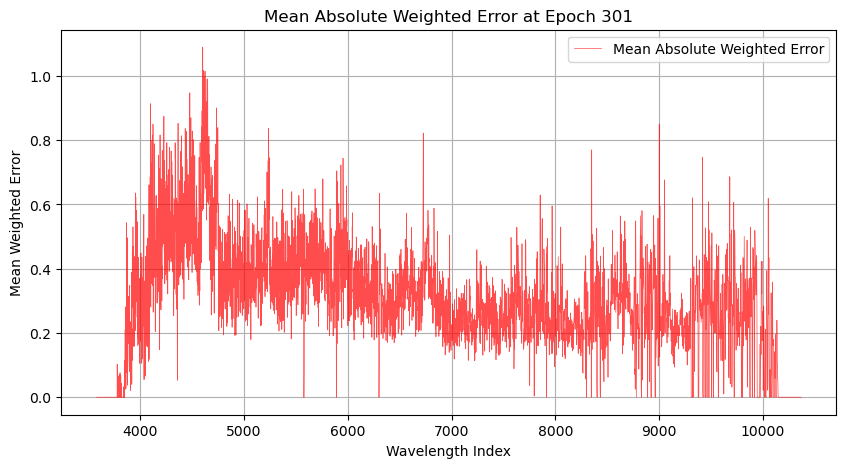

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_401.pth.tar'


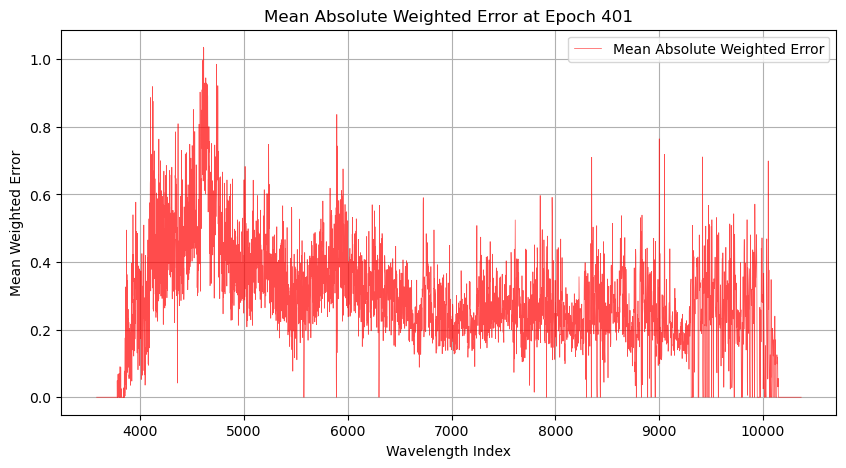

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_501.pth.tar'


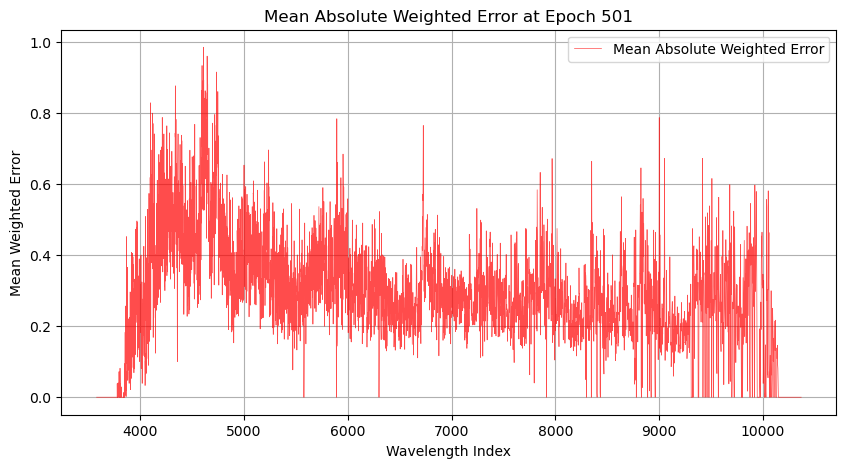

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_601.pth.tar'


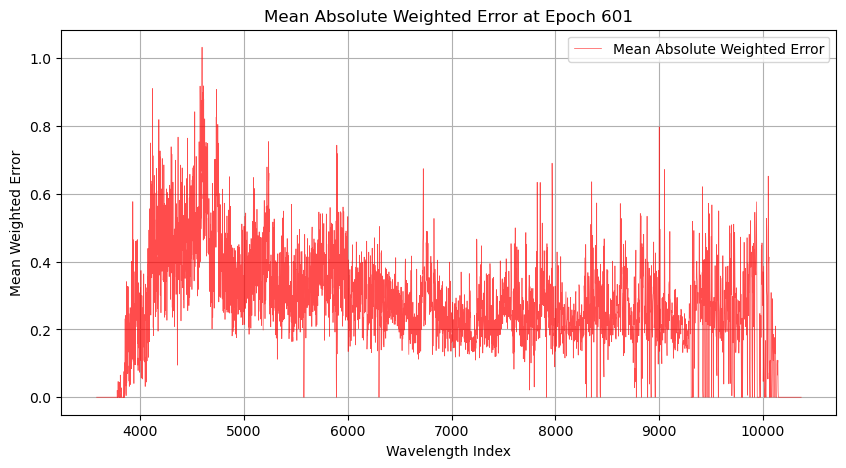

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_701.pth.tar'


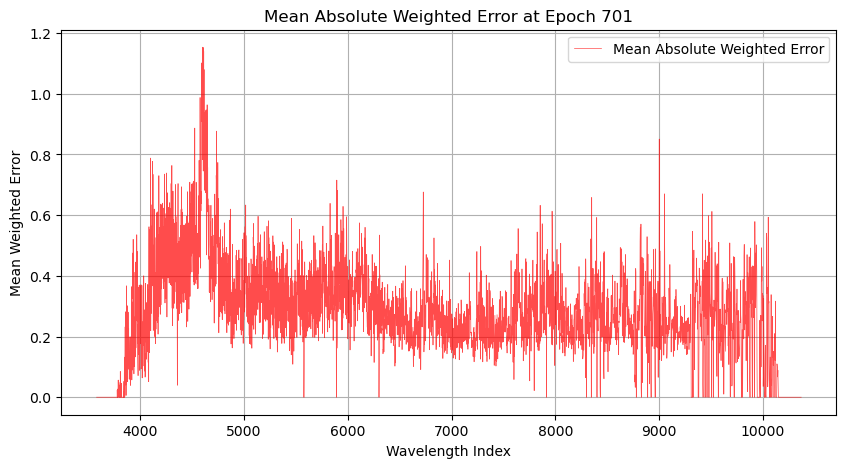

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_801.pth.tar'


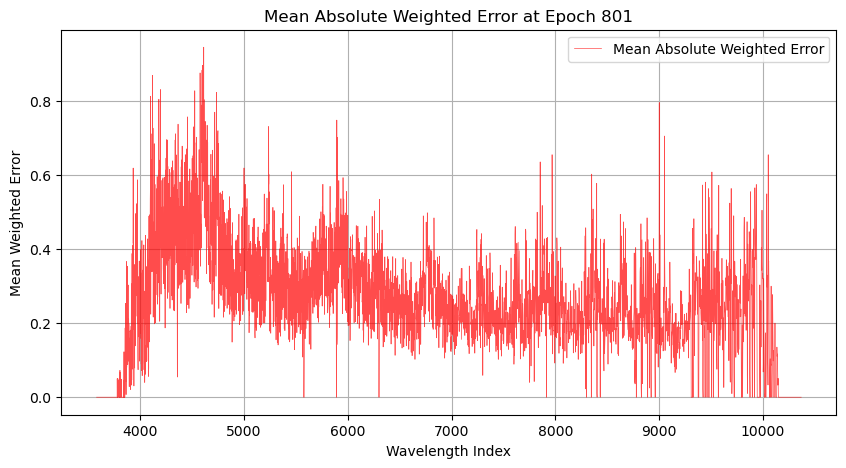

Loading checkpoint '/arc/home/amolinard/DeepGenerativeSpectra/checkpoints/checkpoint_epoch_901.pth.tar'


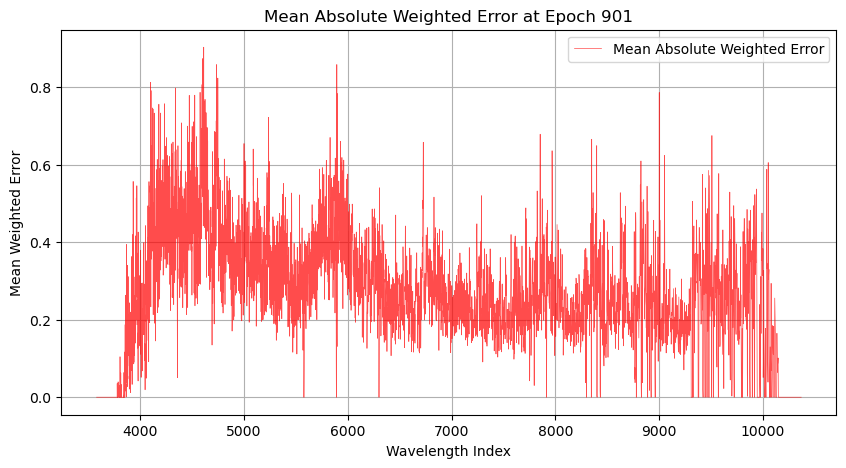

In [60]:
print("initializing device ..")
device = initialize_device()
print("loading config..")
(config, data_path, checkpoints_path, latent_path, plots_path, tensorboard_path,
 batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval) = load_configurations()

# Initialize the dataset and data loader
dataset = QuasarDataset(data_path, max_files=config['training']['max_files'])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Initialize the generator model
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'], config['model']['activation_function']).to(device)

epochs = list(range(0, 1000, 100))
spectrum_indexes = list(random.sample(range(config['training']['max_files']), 10))
plot_errors_spectra_over_epochs(generator, spectrum_indexes, dataset, epochs, device)